<a href="https://colab.research.google.com/github/priyanshusingh-collab/DCGAN-MNIST/blob/main/DCGAN(MNIST).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

Download and prepare the dataset

In [2]:
(x1,y1),(x2,y2) = tf.keras.datasets.mnist.load_data()
training_data = tf.data.Dataset.from_tensor_slices(x1)

In [3]:
def map_function(x):

  x = tf.cast(x, dtype=tf.float32)
  x = tf.divide(x, 127.5) - 1
  x = tf.reshape(x , shape=(28, 28, 1))

  return x

In [4]:
training_data = training_data.map(map_function)

In [5]:
batch_size = 128
training_data = training_data.shuffle(buffer_size = 1024).batch(batch_size)

Build the Model

In [6]:
class generator(tf.keras.models.Model):

  def __init__(self):
    super(generator, self).__init__()

    self.dense1 = tf.keras.layers.Dense(7 * 7 * 128)
    self.reshape1 = tf.keras.layers.Reshape([7, 7, 128])
    self.batch1 = tf.keras.layers.BatchNormalization()
    self.convTrans1 =  tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME", activation="selu")
    self.batch2 = tf.keras.layers.BatchNormalization()
    self.convTrans2 = tf.keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME", activation="tanh")

  def call(self, inputs):

    x = inputs
    x = self.dense1(x)
    x = self.reshape1(x)
    x = self.batch1(x)
    x = self.convTrans1(x)
    x = self.batch2(x)
    x = self.convTrans2(x)

    return x


In [7]:
class discriminator(tf.keras.models.Model):

  def __init__(self):
    super(discriminator, self).__init__()

    self.conv1 = tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME", activation=tf.keras.layers.LeakyReLU(0.2))
    self.do1 = tf.keras.layers.Dropout(0.4)
    self.conv2 = tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",activation=tf.keras.layers.LeakyReLU(0.2))
    self.do2 = tf.keras.layers.Dropout(0.4)
    self.flatten = tf.keras.layers.Flatten()
    self.dense = tf.keras.layers.Dense(1, activation="sigmoid")

  def call(self, inputs):

    x = inputs
    x = self.conv1(x)
    x = self.do1(x)
    x = self.conv2(x)
    x = self.do2(x)
    x = self.flatten(x)
    x = self.dense(x)

    return x

In [8]:
generator_model = generator()
discriminator_model = discriminator()

Note that the generator is bad at producing fakes before training.

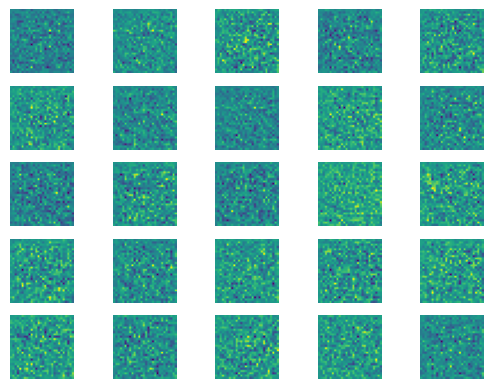

In [9]:
noise = tf.random.normal(shape=(25, 10))
output = generator_model(noise)
for _ in range(25):
  plt.subplot(5,5,_+1)
  plt.axis('off')
  plt.imshow(output[_,:,:,:])
plt.show()


In [10]:
noise_len = 10
input = tf.keras.layers.Input(shape=(noise_len,))
var1 = generator_model(input)
var2 = discriminator_model(var1)
gan = tf.keras.models.Model(inputs=input, outputs=var2)

Train the Model

Epoch : 0 | Time taken for one epoch : 38.2 sec


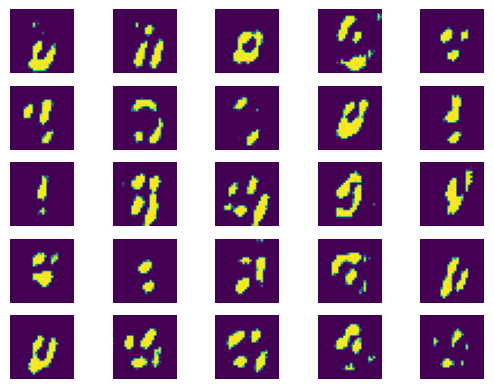

Epoch : 1 | Time taken for one epoch : 40.9 sec
Epoch : 2 | Time taken for one epoch : 27.2 sec


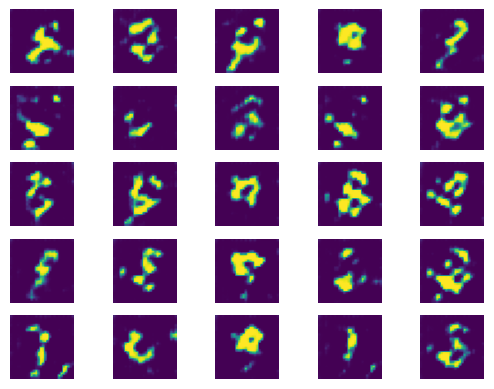

Epoch : 3 | Time taken for one epoch : 28.4 sec
Epoch : 4 | Time taken for one epoch : 27.0 sec


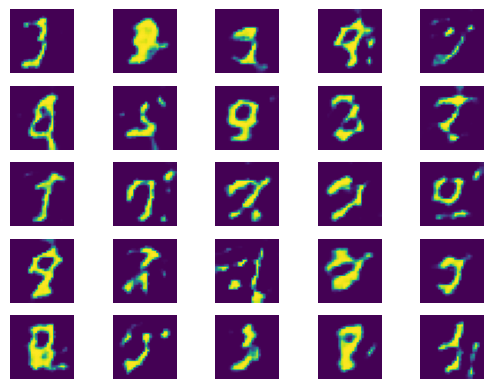

Epoch : 5 | Time taken for one epoch : 40.9 sec
Epoch : 6 | Time taken for one epoch : 27.2 sec


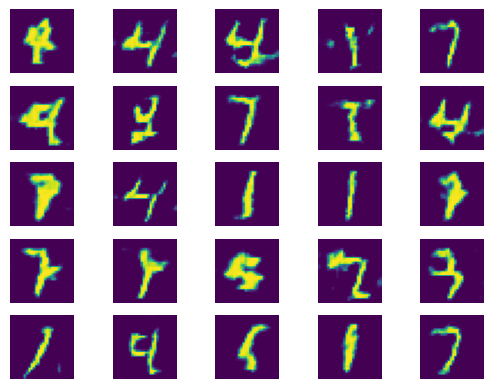

Epoch : 7 | Time taken for one epoch : 27.0 sec
Epoch : 8 | Time taken for one epoch : 27.2 sec


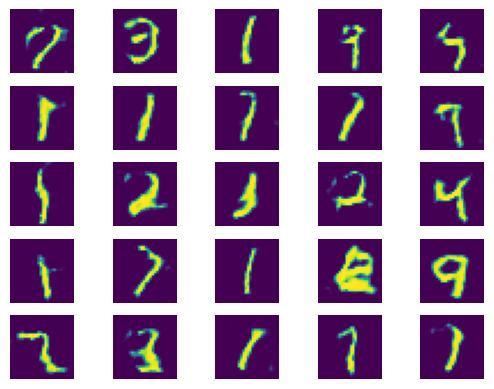

Epoch : 9 | Time taken for one epoch : 27.1 sec
Epoch : 10 | Time taken for one epoch : 28.6 sec


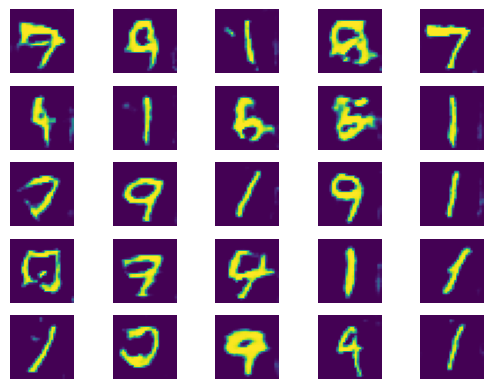

Epoch : 11 | Time taken for one epoch : 27.5 sec
Epoch : 12 | Time taken for one epoch : 26.9 sec


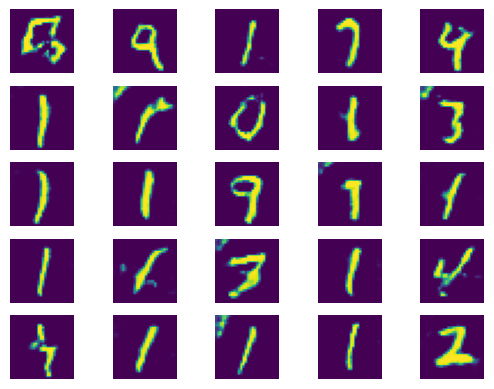

Epoch : 13 | Time taken for one epoch : 41.0 sec
Epoch : 14 | Time taken for one epoch : 26.8 sec


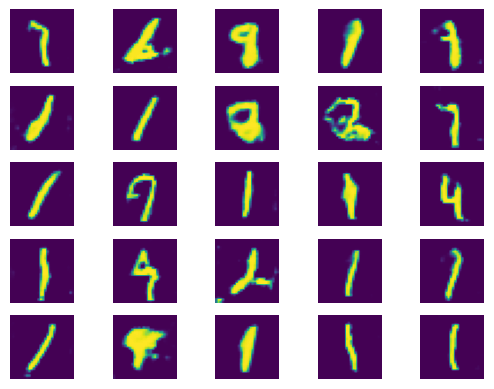

Epoch : 15 | Time taken for one epoch : 27.3 sec
Epoch : 16 | Time taken for one epoch : 27.5 sec


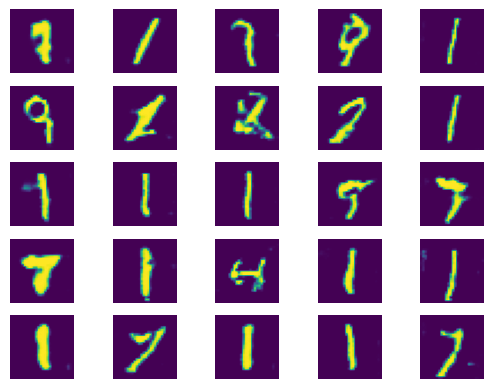

Epoch : 17 | Time taken for one epoch : 26.9 sec
Epoch : 18 | Time taken for one epoch : 27.2 sec


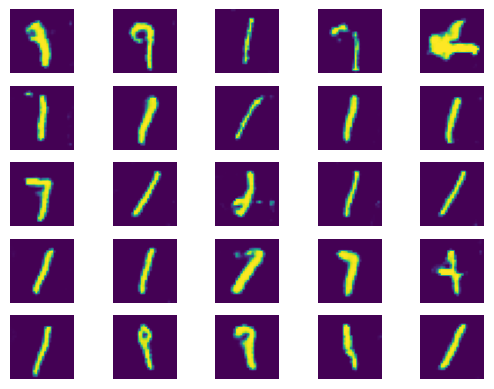

Epoch : 19 | Time taken for one epoch : 27.1 sec


In [11]:
dis_loss_func = tf.keras.losses.BinaryCrossentropy()
gan_loss_func = tf.keras.losses.BinaryCrossentropy()
discriminator_optimizer = tf.keras.optimizers.Adam()
gan_optimizer = tf.keras.optimizers.legacy.Adam()

epochs = 20
for epoch in range(epochs):
  tic = time.time()
  for images in training_data:
    batch_size = images.shape[0]

    #discriminator training
    noise = tf.random.normal(shape=(batch_size, noise_len))
    fake_images = generator_model(noise)
    combined_images = tf.concat([images, fake_images],axis=0)

    discriminator_ytrue = tf.constant([[1.]]*batch_size + [[0.]]* batch_size)

    with tf.GradientTape() as tape:
      discriminator_ypred = discriminator_model(combined_images)
      discriminator_loss = dis_loss_func(discriminator_ytrue, discriminator_ypred)
    gradients = tape.gradient(discriminator_loss, discriminator_model.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients,discriminator_model.trainable_variables))

    discriminator_model.trainable = False

    #generator training
    noise = tf.random.normal(shape=(batch_size, noise_len))
    gan_ytrue = tf.constant([[1.]] * batch_size)

    with tf.GradientTape() as tape:
      gan_ypred = gan(noise)
      gan_loss = gan_loss_func(gan_ytrue, gan_ypred)

    gradients = tape.gradient(gan_loss, gan.trainable_variables)
    gan_optimizer.apply_gradients(zip(gradients,gan.trainable_variables))

    discriminator_model.trainable = True

  toc = time.time()
  print("Epoch : {} | Time taken for one epoch : {} sec".format(epoch, round(toc-tic, 1)))
  if (epoch % 2 == 0):
    noise = tf.random.normal(shape=(25, noise_len))
    output = generator_model(noise)
    for _ in range(25):
      plt.subplot(5,5,_+1)
      plt.axis('off')
      plt.imshow(output[_,:,:,:])
    plt.show()